In [69]:
import librosa
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import random

import torchaudio
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from IPython.display import Audio, display
import umap

## Setup

In [70]:
sf.info("./data/wavfiles/101308-0.wav")

./data/wavfiles/101308-0.wav
samplerate: 22050 Hz
channels: 1
duration: 3.000 s
format: WAV (Microsoft) [WAV]
subtype: 32 bit float [FLOAT]

In [71]:
SAMPLE_RATE = 22050
SECONDS = 3

In [72]:
def plot_wave(waveform):
    plt.figure(figsize=(10, 4))
    plt.plot(waveform.t().numpy())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Waveform')
    plt.show()

def plot_spec(waveform):
    plt.figure(figsize=(10, 4))
    plt.specgram(waveform[0].numpy(), Fs=SAMPLE_RATE, noverlap=240, cmap='viridis', aspect='auto')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Spectrogram')
    plt.colorbar()
    plt.show()

def show_wav(f):
  wave = torchaudio.load(f"./data/wavfiles/{f}", normalize=True)[0][0]
  display(Audio(wave, rate=SAMPLE_RATE))

## Dataframe

In [73]:
df = pd.read_csv("./data/bird_songs_metadata.csv")

species = df.species.unique()
species

array(['bewickii', 'polyglottos', 'migratorius', 'melodia', 'cardinalis'],
      dtype=object)

In [74]:
species_to_int = {s: i for i, s in enumerate(species)}
int_to_species = list(species)

In [ ]:
data = [(df.filename[i], species_to_int[df.species[i]]) for i in range(df.shape[0])]
random.shuffle(data)
test_set = data[:len(data) // 5]
train_set = data[len(data) // 5:]

## Model

In [76]:
embedding_size = 16
epoches = 30
batch_size = 200
output_size = len(species)

In [77]:
class BirdCallData(Dataset):
    def __init__(self, data):
        self.data = data
        self.length = len(data)

    def __len__(self):
        return self.length

    def __getitem__(self, i):
        f, l = self.data[i]
        wave = torchaudio.load(f"data/wavfiles/{f}", normalize=True)[0][0]
        enc_label = torch.zeros(output_size)
        enc_label[l] = 1.
        return wave, enc_label

class BirdCallModel(nn.Module):
    def __init__(self):
        super(BirdCallModel, self).__init__()
        self.lfcc_extractor = torchaudio.transforms.LFCC(
            sample_rate=SAMPLE_RATE,
            n_lfcc=64
        )
        self.lstm = nn.LSTM(64, 32, 1, batch_first=True)
        self.embed = nn.Linear(32, embedding_size)
        self.classify = nn.Sequential(
            nn.ReLU(),
            nn.Linear(embedding_size, output_size)
        )
        

        
    def forward(self, x):
        x = self.lfcc_extractor(x)
        x = x.permute(0, 2, 1)
        a, (b, c) = self.lstm(x)
        x = self.embed(c)
        x = self.classify(x)
        return x[0]
    
    def run_embed(self, x):
        x = self.lfcc_extractor(x)
        x = x.permute(1, 0)
        a, (b, c) = self.lstm(x)
        x = self.embed(c)
        return x[0]

In [78]:
model = BirdCallModel()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
train_loader = DataLoader(dataset=BirdCallData(train_set), batch_size=batch_size, shuffle=True)

In [79]:
from tqdm import tqdm


model.train()
train_loss = []
for epoch in range(epoches):
    losses = []
    for waves, enc_labels in tqdm(train_loader):
        optimizer.zero_grad()
        out = model(waves)

        l = loss(out, enc_labels)
        
        l.backward()
    
        losses.append(l.item())

        optimizer.step()
    train_loss.append(np.mean(losses))
    print(f"Epoch {epoch+1} | Avg loss {train_loss[-1]:.4f}")

100%|██████████| 22/22 [00:15<00:00,  1.40it/s]


Epoch 1 | Avg loss 12.9219


100%|██████████| 22/22 [00:15<00:00,  1.42it/s]


Epoch 2 | Avg loss 3.8868


100%|██████████| 22/22 [00:15<00:00,  1.45it/s]


Epoch 3 | Avg loss 2.3835


100%|██████████| 22/22 [00:14<00:00,  1.52it/s]


Epoch 4 | Avg loss 1.7528


100%|██████████| 22/22 [00:14<00:00,  1.55it/s]


Epoch 5 | Avg loss 1.3994


100%|██████████| 22/22 [00:14<00:00,  1.56it/s]


Epoch 6 | Avg loss 1.1883


100%|██████████| 22/22 [00:13<00:00,  1.58it/s]


Epoch 7 | Avg loss 1.0443


100%|██████████| 22/22 [00:13<00:00,  1.57it/s]


Epoch 8 | Avg loss 0.9414


100%|██████████| 22/22 [00:13<00:00,  1.58it/s]


Epoch 9 | Avg loss 0.8477


100%|██████████| 22/22 [00:13<00:00,  1.58it/s]


Epoch 10 | Avg loss 0.7862


100%|██████████| 22/22 [00:13<00:00,  1.61it/s]


Epoch 11 | Avg loss 0.7327


100%|██████████| 22/22 [00:13<00:00,  1.63it/s]


Epoch 12 | Avg loss 0.6807


100%|██████████| 22/22 [00:13<00:00,  1.63it/s]


Epoch 13 | Avg loss 0.6420


100%|██████████| 22/22 [00:13<00:00,  1.62it/s]


Epoch 14 | Avg loss 0.6015


100%|██████████| 22/22 [00:13<00:00,  1.64it/s]


Epoch 15 | Avg loss 0.5630


100%|██████████| 22/22 [00:13<00:00,  1.63it/s]


Epoch 16 | Avg loss 0.5374


100%|██████████| 22/22 [00:13<00:00,  1.62it/s]


Epoch 17 | Avg loss 0.5157


100%|██████████| 22/22 [00:13<00:00,  1.61it/s]


Epoch 18 | Avg loss 0.4845


100%|██████████| 22/22 [00:14<00:00,  1.56it/s]


Epoch 19 | Avg loss 0.4631


100%|██████████| 22/22 [00:13<00:00,  1.58it/s]


Epoch 20 | Avg loss 0.4392


100%|██████████| 22/22 [00:13<00:00,  1.59it/s]


Epoch 21 | Avg loss 0.4204


100%|██████████| 22/22 [00:13<00:00,  1.60it/s]


Epoch 22 | Avg loss 0.3922


100%|██████████| 22/22 [00:13<00:00,  1.58it/s]


Epoch 23 | Avg loss 0.3794


100%|██████████| 22/22 [00:13<00:00,  1.60it/s]


Epoch 24 | Avg loss 0.3631


100%|██████████| 22/22 [00:13<00:00,  1.57it/s]


Epoch 25 | Avg loss 0.3455


100%|██████████| 22/22 [00:13<00:00,  1.61it/s]


Epoch 26 | Avg loss 0.3333


100%|██████████| 22/22 [00:13<00:00,  1.58it/s]


Epoch 27 | Avg loss 0.3220


100%|██████████| 22/22 [00:13<00:00,  1.60it/s]


Epoch 28 | Avg loss 0.2983


100%|██████████| 22/22 [00:13<00:00,  1.61it/s]


Epoch 29 | Avg loss 0.2762


100%|██████████| 22/22 [00:13<00:00,  1.63it/s]

Epoch 30 | Avg loss 0.2653


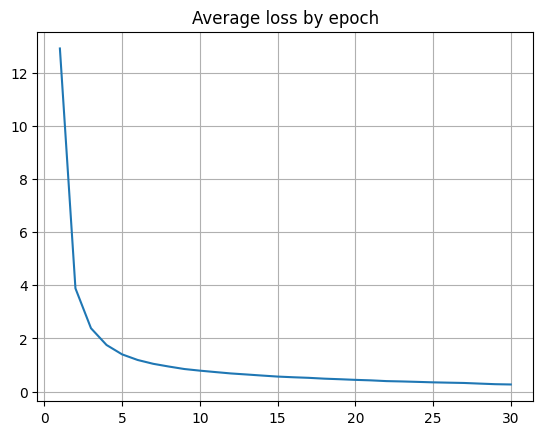

In [80]:
plt.plot(range(1, epoches+1), train_loss)
plt.title("Average loss by epoch")
plt.grid()
plt.show()

In [81]:
model.eval()
test_embeds = [(lambda x: x / np.linalg.norm(x))(model.run_embed(torchaudio.load(f"./data/wavfiles/{f}", normalize=True)[0][0]).detach().numpy()) for f, _ in test_set]
test_labels = [c for _, c in test_set]

## UMAP

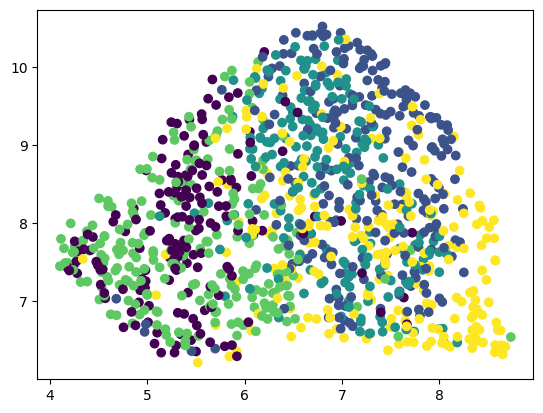

In [82]:
u = umap.UMAP(n_neighbors=30, min_dist=0.3, spread=0.4).fit_transform(test_embeds)

plt.scatter(u[:,0], u[:,1], c=test_labels)
plt.show()

## Similar bird calls

In [83]:
def find_closest(i):
    distances = []
    for j in range(len(test_embeds)):
        if (i == j) or (test_labels[i] == test_labels[j]): continue
        distances.append((j, np.linalg.norm(test_embeds[i] - test_embeds[j])))
    
    found = []
    for j in sorted(distances, key=lambda x: x[1]):
        if not test_labels[j[0]] in found:
            found.append(test_labels[j[0]])
            yield j

In [84]:
i = 0

f, l = test_set[i]
print(f"Closest calls to '{int_to_species[l]}':")
show_wav(f)

for j, dist in find_closest(i):
    fc, lc = test_set[j]
    print(f"Species '{int_to_species[lc]}' | Dist {dist:.6f}")
    show_wav(fc)

Closest calls to 'cardinalis':


Species 'migratorius' | Dist 0.256643


Species 'polyglottos' | Dist 0.279997


Species 'bewickii' | Dist 0.298647


Species 'melodia' | Dist 0.304372
